## Refine Endothelial cell annotations for large intestine - relabelling uncertain cells based on majority voting

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import sys
import os
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import ast

In [3]:
sc.logging.print_header()

scanpy==1.8.0 anndata==0.8.0 umap==0.4.6 numpy==1.20.1 scipy==1.6.1 pandas==1.3.5 scikit-learn==0.24.1 statsmodels==0.13.5 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3 pynndescent==0.5.2


In [4]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [5]:
sc.set_figure_params(
    dpi=200,dpi_save=300,
    fontsize=12,
    frameon=False,
    transparent=True,
)

In [6]:
sns.set_style(style="white")
sns.set_context(context="paper")

In [7]:
adata = sc.read_h5ad('/nfs/team205/ao15/Megagut/Annotations_v3/h5ad/disease/compartments/Endo_pooled_disease.gene_cellbender.good_qc_cluster_mito80.stringent_doublet_removed.hvg7500_noCC.scvi_output.lv20_batch256.with_raw_counts.scArches_broad_pred.20230124.h5ad')

In [8]:
adata

AnnData object with n_obs × n_vars = 8121 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_spli

In [9]:
adata_scanvi = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/metadata/X_scANVI/disease/disease_fine_annot_predict_Endo_20230226.csv.gz',compression='gzip',index_col=0)

In [10]:
adata_scanvi

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,LV11,LV12,LV13,LV14,LV15,LV16,LV17,LV18,LV19,LV20
index,,,,,,,,,,,,,,,,,,,,
AAAGCAAAGAGCTGGT-4918STDY7273964,-0.085672,-0.626934,0.046728,0.074449,-1.022110,-1.373578,0.941454,0.028259,0.043873,0.494943,0.061282,-0.080914,-0.806504,-0.236679,-0.804982,-0.026352,-0.096902,-1.352366,-0.951052,-0.064367
AACCATGTCCAGTAGT-4918STDY7273964,0.513567,0.433343,-0.037089,0.019089,0.934302,-1.784075,0.443836,0.028841,0.035380,0.395802,0.085531,-0.146290,-1.410292,-0.069396,-0.603088,0.026918,-0.144987,0.274203,-1.536590,-0.073253
AACTGGTGTAGCTCCG-4918STDY7273964,-0.300526,0.388939,0.028503,0.080027,-1.776161,-1.615989,0.842389,0.049374,0.014130,0.143625,-0.000241,-0.076925,-0.334051,-0.239699,-0.973325,-0.060877,-0.098035,-1.361413,-0.522220,-0.003920
AAGCCGCTCGTACGGC-4918STDY7273964,0.618780,0.884257,-0.000787,0.006789,0.465004,1.587941,-0.299724,-0.035661,0.071659,-0.675425,0.029039,-0.019870,-0.837068,-0.134919,0.120280,0.005912,-0.092750,-0.929852,-0.773855,-0.064567
AAGGCAGGTAGCACGA-4918STDY7273964,0.853992,0.063295,-0.025488,0.018689,0.183490,0.816863,-1.565917,-0.041497,0.004903,-0.169736,0.015550,-0.048722,0.295476,-0.718855,0.013665,0.005532,-0.108206,-0.420817,-0.554128,-0.068967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGACTTTCCTACAGA-GSM4546346,1.073934,-0.450200,0.058139,0.057115,-0.174826,0.893707,-0.347016,-0.048292,0.032940,-0.238452,-0.077263,0.022652,0.139978,0.811984,-0.652261,-0.008505,0.067252,-0.027913,0.189460,-0.112748
TTGCGTCTCCCAAGTA-GSM4546346,0.474677,0.881596,-0.020935,-0.024452,0.321261,-1.975901,0.685044,0.044340,0.006979,0.001526,0.008774,-0.127855,0.688731,-0.111170,-0.326338,-0.050552,-0.150345,-1.416278,-1.117107,-0.014110
TTTACTGCAAACCCAT-GSM4546346,0.264444,-0.572553,0.072592,0.047862,-1.265912,-0.235569,-1.290525,-0.045115,0.022997,0.240387,0.025141,-0.030886,-0.205228,0.316641,-0.747930,-0.071070,-0.056181,-0.937858,0.007092,-0.015855


In [11]:
adata.obsm['X_scANVI'] = adata_scanvi

In [12]:
adata_meta = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/metadata/disease/20230308/scanvi/disease_fine_annot_predict_Endo_20230226.csv',index_col=0)

In [13]:
adata_meta

,latent_cell_probability,latent_RT_efficiency,cecilia22_predH,cecilia22_predH_prob,cecilia22_predH_uncertain,cecilia22_predL,cecilia22_predL_prob,cecilia22_predL_uncertain,elmentaite21_pred,elmentaite21_pred_prob,...,martin19_pred_uncertain,warner20_pred,warner20_pred_prob,warner20_pred_uncertain,broad_predicted_labels,broad_predicted_labels_uncert,fine_annot,fine_predicted_labels,fine_predicted_labels_uncertainty,scanvi_pred
index,,,,,,,,,,,,,,,,,,,,,
AAAGCAAAGAGCTGGT-4918STDY7273964,0.999677,1.289961,Endothelial cells,1.000000,Endothelial cells,Endothelial cells,1.000000,Endothelial cells,arterial capillary,0.976345,...,VE art,VE art,0.421193,VE art,Endothelial,0.000000e+00,Unknown,EC_arterial_2,1.192093e-07,EC_arterial_2
AACCATGTCCAGTAGT-4918STDY7273964,0.999603,1.141778,Endothelial cells,0.999999,Endothelial cells,Endothelial cells,1.000000,Endothelial cells,arterial capillary,0.999825,...,VE art,VE art,0.720615,VE art,Endothelial,5.960464e-08,Unknown,EC_arterial_1,2.384186e-07,EC_arterial_1
AACTGGTGTAGCTCCG-4918STDY7273964,0.999859,2.151045,Endothelial cells,1.000000,Endothelial cells,Endothelial cells,1.000000,Endothelial cells,arterial capillary,0.962370,...,VE art,VE cap,0.731195,VE cap,Endothelial,0.000000e+00,Unknown,EC_arterial_2,0.000000e+00,EC_arterial_2
AAGCCGCTCGTACGGC-4918STDY7273964,0.999608,1.534861,Endothelial cells,1.000000,Endothelial cells,Endothelial cells,1.000000,Endothelial cells,Mature venous EC,1.000000,...,VE ven,VE ven,0.920311,VE ven,Endothelial,0.000000e+00,Unknown,EC_venous,0.000000e+00,EC_venous
AAGGCAGGTAGCACGA-4918STDY7273964,0.999894,2.819811,Endothelial cells,1.000000,Endothelial cells,Endothelial cells,1.000000,Endothelial cells,Mature venous EC,1.000000,...,VE ven,VE ven,0.914516,VE ven,Endothelial,0.000000e+00,Unknown,EC_venous,0.000000e+00,EC_venous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGACTTTCCTACAGA-GSM4546346,0.999876,2.817957,Endothelial cells,1.000000,Endothelial cells,Endothelial cells,1.000000,Endothelial cells,arterial capillary,0.886489,...,VE cap,VE ven,0.497251,VE ven,Endothelial,0.000000e+00,Unknown,EC_venous,2.599937e-01,EC_cycling
TTGCGTCTCCCAAGTA-GSM4546346,0.999782,2.121822,Endothelial cells,1.000000,Endothelial cells,Endothelial cells,1.000000,Endothelial cells,arterial capillary,0.415836,...,VE art,VE cap,0.556569,VE cap,Endothelial,0.000000e+00,Unknown,EC_arterial_2,3.600587e-01,EC_arterial_2
TTTACTGCAAACCCAT-GSM4546346,0.999269,1.186025,Endothelial cells,0.999817,Endothelial cells,Endothelial cells,0.999878,Endothelial cells,Mature venous EC,0.350810,...,VE ven,VE ven,0.745317,VE ven,Endothelial,0.000000e+00,Unknown,EC_venous,8.000743e-02,EC_venous


In [13]:
adata.obs = adata_meta

In [14]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


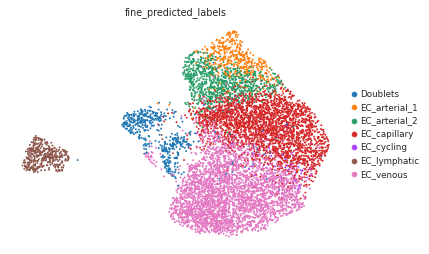

In [15]:
sc.pl.umap(adata, color=['fine_predicted_labels'])

In [16]:
adata.obs.donor_disease.unique()

['PIBD', 'cancer', 'UC', 'CD']
Categories (4, object): ['CD', 'PIBD', 'UC', 'cancer']

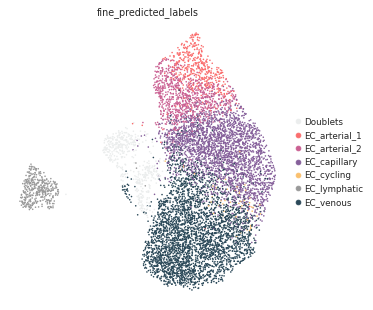

In [17]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata,color='fine_predicted_labels',palette = ['#ebeded',#doublets
                                                          '#fa6e6e',#arterial 1
                                                          '#ca6092',#arterial 2
                                                          '#855f9a',#capillary
                                                          '#fac06e',#cycling
                                                          '#999999',#lymphatic
                                                          '#2a4858' #venous
                                                         ]
           ,size=10,save='Endo_scanviannot_predictedlabels.pdf')

In [18]:
adata.X.max()

4818.0

In [19]:
adata.layers['counts'] = adata.X

In [20]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [21]:
marker_genes_dict = {'General EC markers':['PECAM1','CD36'],
                     'General arterial markers':['GJA4','HEY1','CXCL12'],
                     'Arterial 1':['SEMA3G','IGFBP3','FBLN2','FBLN5','ELN'],
                     'Arterial 2':['BTNL9','ALPL'],
                     'Capillary':['RGCC','COL4A1','COL4A2','IL32','MCAM','MYO1B'],
                     'Cycling':['MKI67','TOP2A'],
                     'Lymphatic':['CCL21','TFF3','PROX1','NTS'],
                     'Venous':['ACKR1','CCL14','SELE','TNFRSF6B']}

In [22]:
adata

AnnData object with n_obs × n_vars = 8121 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_spli

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


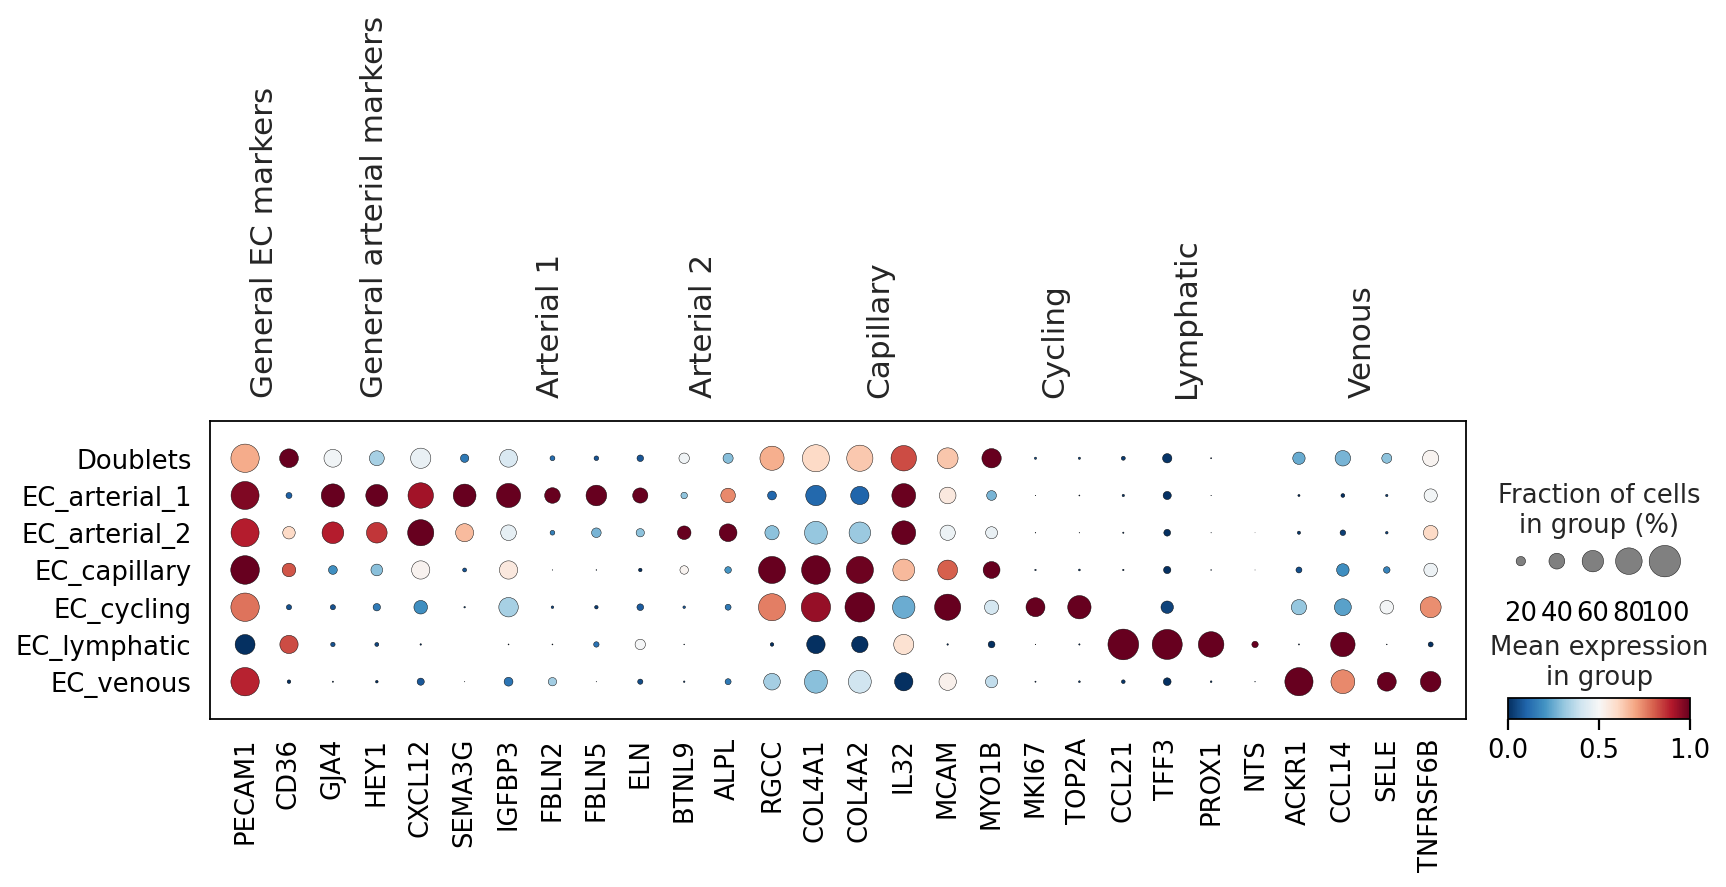

In [23]:
sc.set_figure_params(dpi_save = 300)
sc.pl.dotplot(adata,var_names=marker_genes_dict,groupby='fine_predicted_labels',color_map='RdBu_r', standard_scale='var')

In [24]:
uncert = adata.obs[['fine_predicted_labels','fine_predicted_labels_uncertainty']] 

In [25]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(adata.obs['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.4599775671958923


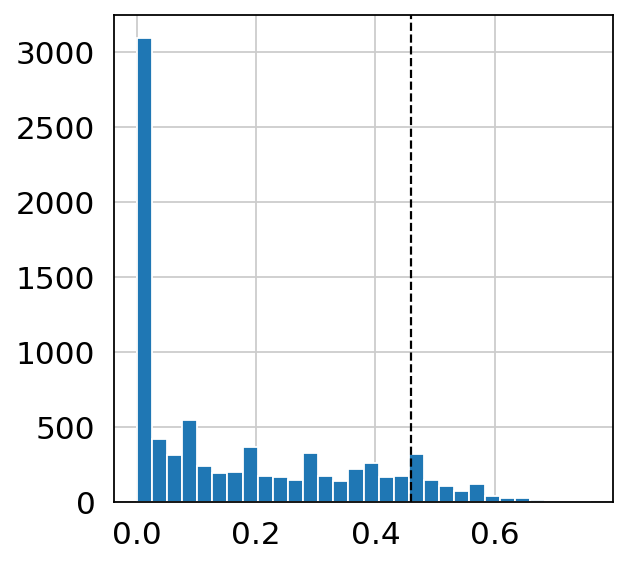

In [26]:
#plot uncertainty distribution
plt.hist(adata.obs['fine_predicted_labels_uncertainty'], bins=30)
plt.axvline(x=p, color='black', linestyle='dashed', linewidth=1)
plt.savefig('Endo_scanviannot_uncertdist.pdf', format='pdf')
plt.show()

In [27]:
uncert['fine_predicted_labels'] = uncert['fine_predicted_labels'].cat.add_categories('Unknown')

<ipython-input-27-905f2ed234d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncert['fine_predicted_labels'] = uncert['fine_predicted_labels'].cat.add_categories('Unknown')


In [28]:
adata.obs['fine_predicted_labels'].unique()

['EC_arterial_2', 'EC_arterial_1', 'EC_venous', 'EC_lymphatic', 'EC_capillary', 'Doublets', 'EC_cycling']
Categories (7, object): ['Doublets', 'EC_arterial_1', 'EC_arterial_2', 'EC_capillary', 'EC_cycling', 'EC_lymphatic', 'EC_venous']

In [29]:
#mark cells are unknown based on cut off of 90th percentile rounded to the nearest second decimal
uncert.loc[uncert["fine_predicted_labels_uncertainty"] > 0.52, "fine_predicted_labels"] = "Unknown"

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [30]:
adata.obs['fine_predicted_labels_uncertflagged'] = adata.obs['fine_predicted_labels']

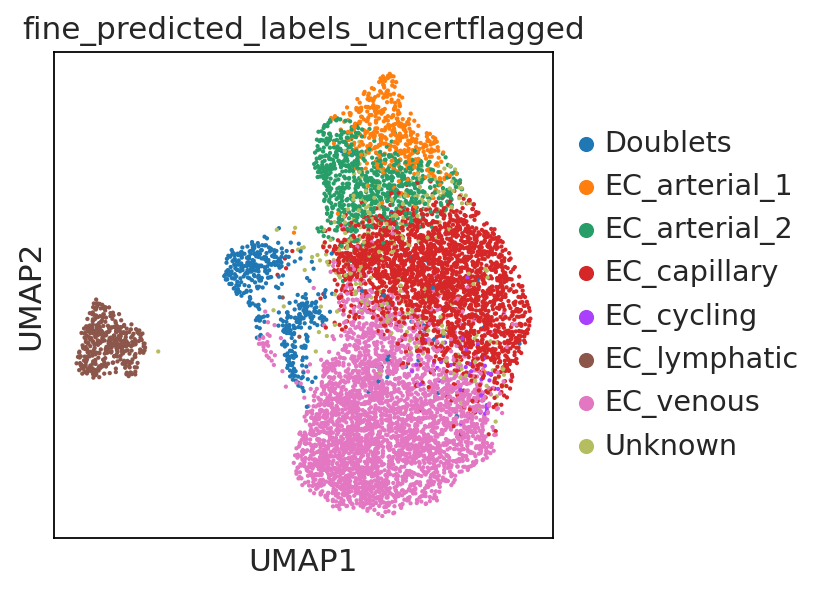

In [31]:
ON = {O:N for O,N in zip(uncert.index,uncert["fine_predicted_labels"])}
adata.obs["fine_predicted_labels_uncertflagged"] = [ON[O] if O in ON else N for O,N in zip(adata.obs_names, adata.obs["fine_predicted_labels_uncertflagged"])]
sc.pl.umap(adata,color='fine_predicted_labels_uncertflagged')

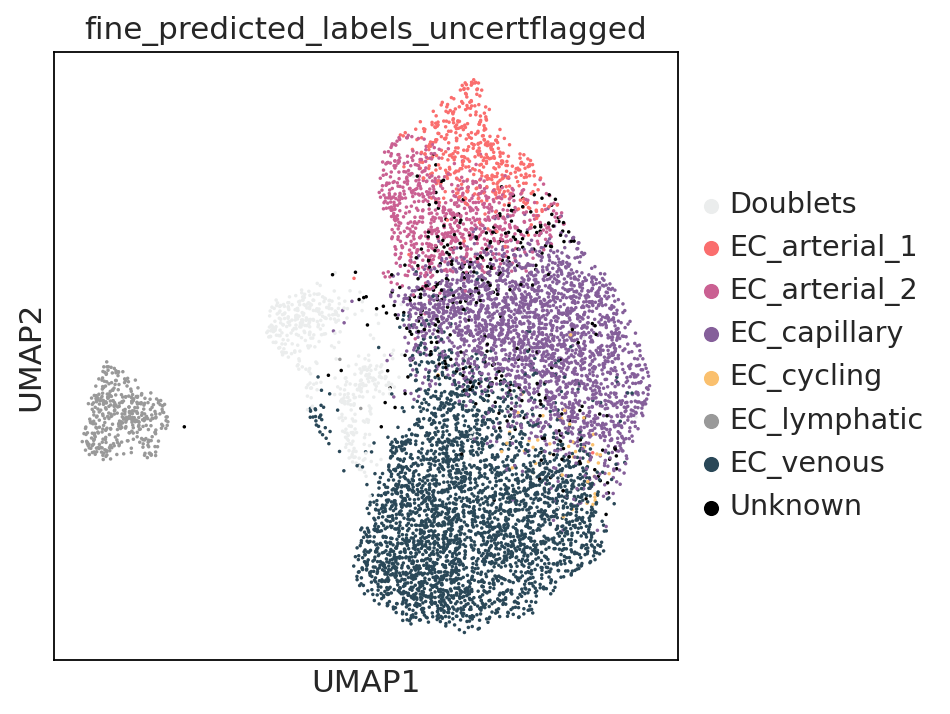

In [32]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata,color='fine_predicted_labels_uncertflagged',palette = ['#ebeded',#doublets
                                                          '#fa6e6e',#arterial 1
                                                          '#ca6092',#arterial 2
                                                          '#855f9a',#capillary
                                                          '#fac06e',#cycling
                                                          '#999999',#lymphatic
                                                          '#2a4858', #venous
'#000000'#unknown
                                                                       ],size=10,save='Endo_scanviannot_uncertflagged.pdf')

In [33]:
annot = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/disease_annot/resolved_annot/Endo_disease_annot.csv',index_col=0)

In [34]:
adata.obs['fine_predicted_labels_resolved'] = annot.fine_predicted_labels_resolved

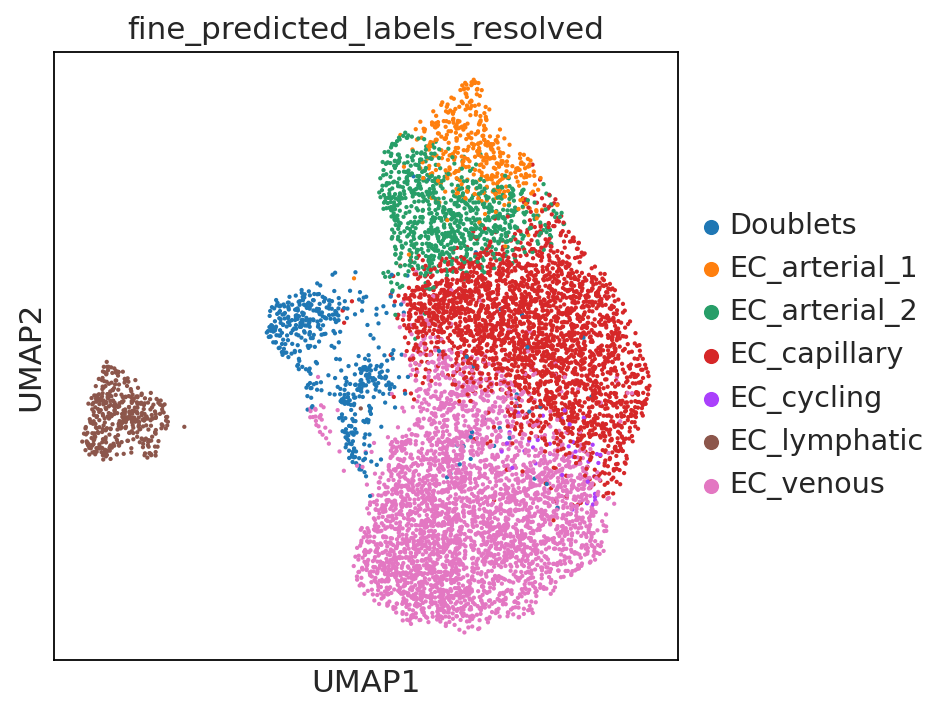

In [35]:
sc.pl.umap(adata,color='fine_predicted_labels_resolved')

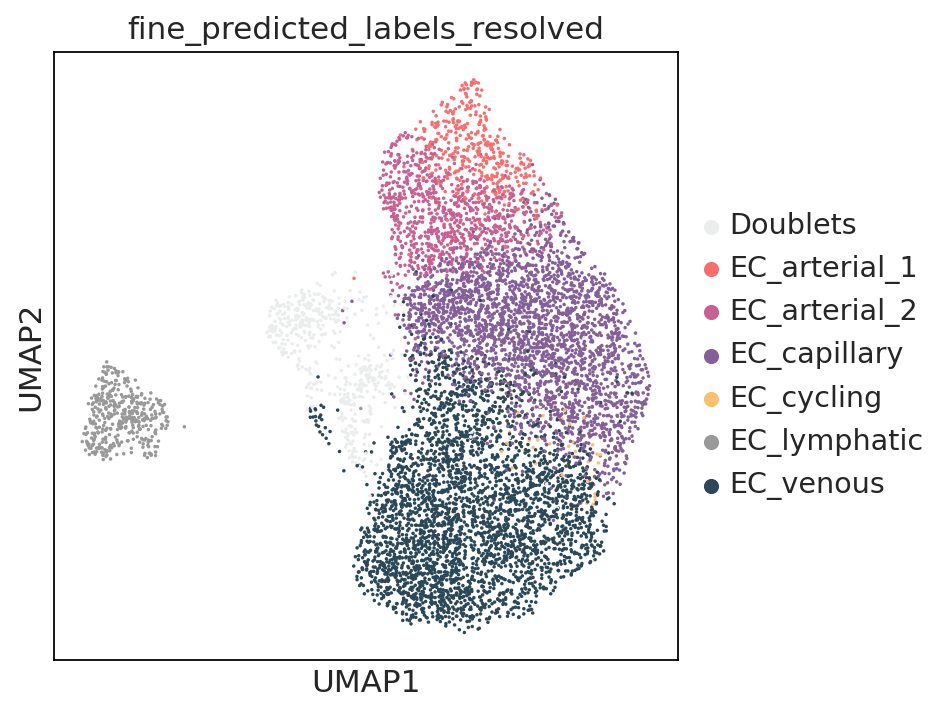

In [36]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata,color='fine_predicted_labels_resolved',palette = ['#ebeded',#doublets
                                                          '#fa6e6e',#arterial 1
                                                          '#ca6092',#arterial 2
                                                          '#855f9a',#capillary
                                                          '#fac06e',#cycling
                                                          '#999999',#lymphatic
                                                          '#2a4858', #venous
 ],size=10,save='Endo_scanviannot_resolved.pdf')

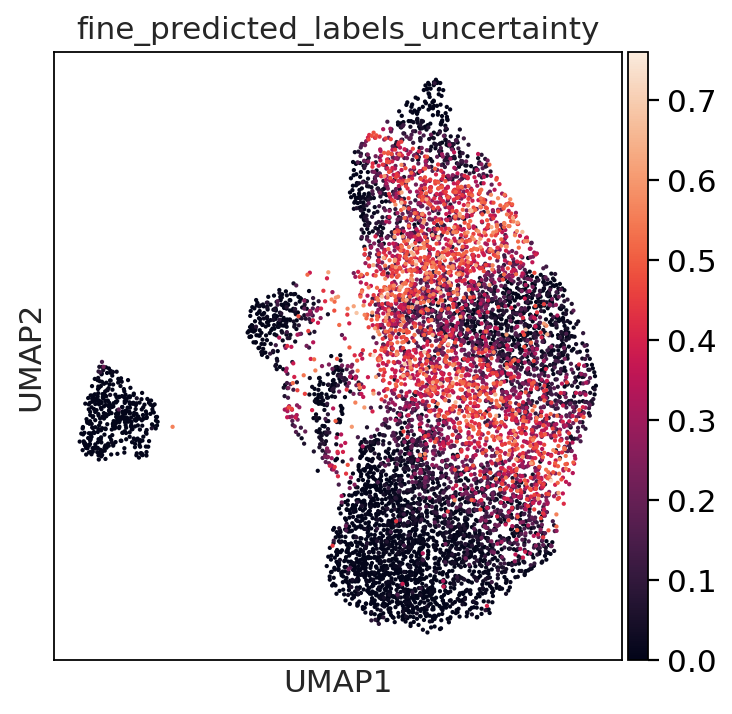

In [37]:
sc.pl.umap(adata,color='fine_predicted_labels_uncertainty',save='Endo_scanviannot_uncertainty.pdf')

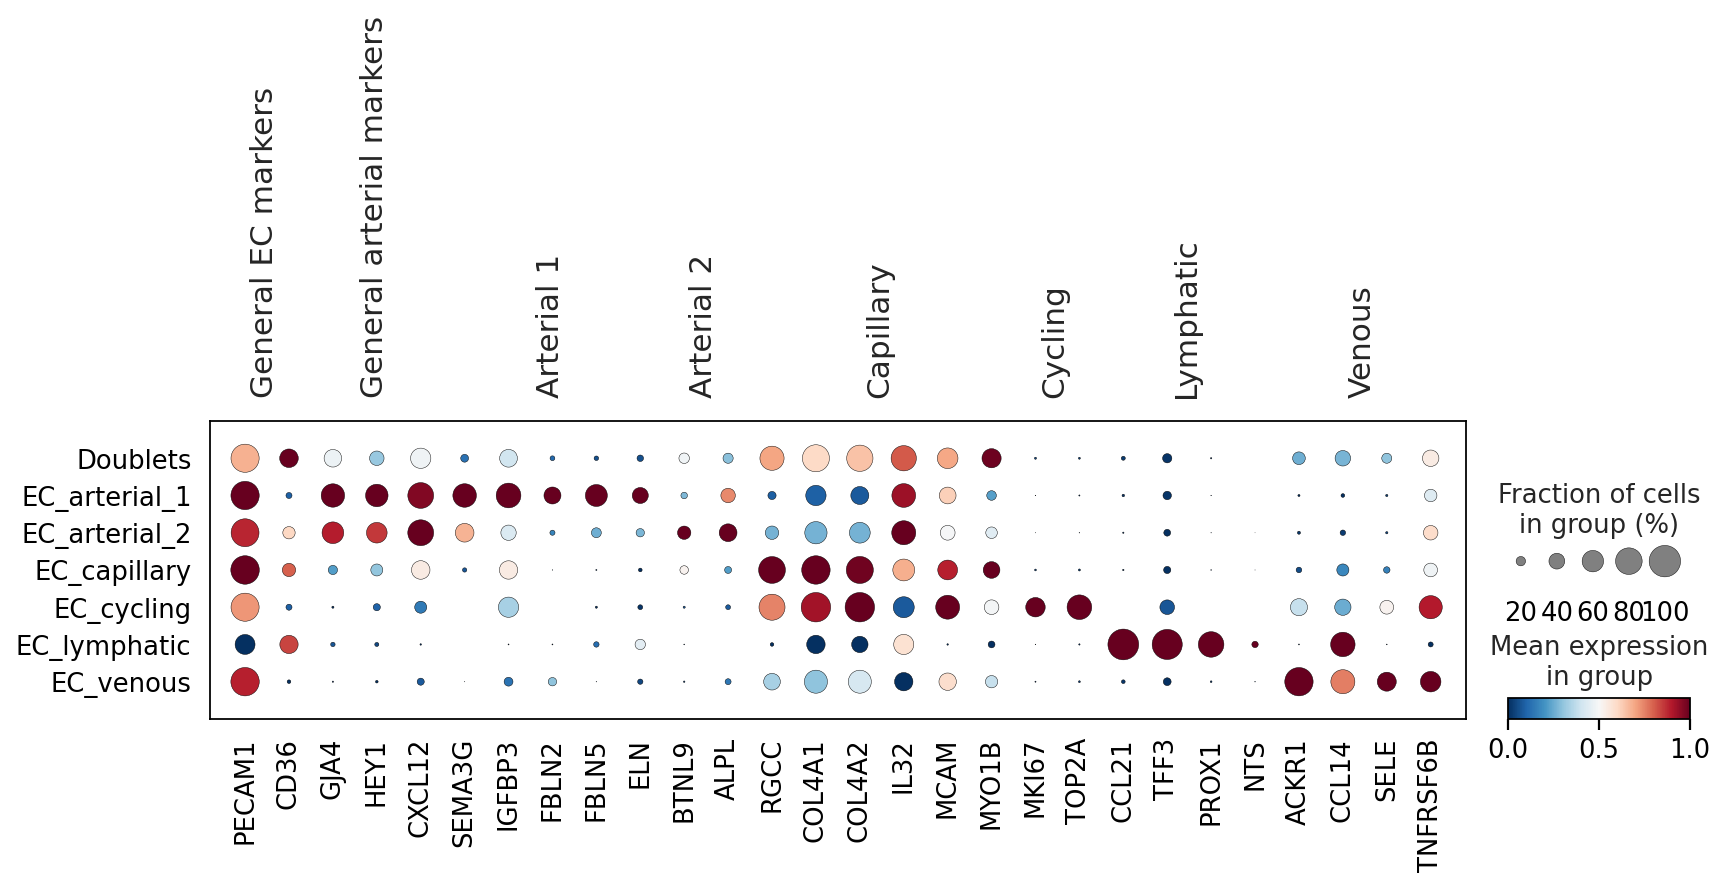

In [38]:
sc.set_figure_params(dpi_save = 300)
sc.pl.dotplot(adata,var_names=marker_genes_dict,groupby='fine_predicted_labels_resolved',color_map='RdBu_r', standard_scale='var',save='Endo_scanviannot_resvoledmarkers.pdf')

In [39]:
colors={
    'Doublets':'#ebeded',
    'EC_venous': '#2a4858',
  'Mast': '#826e91',
  'EC_capillary': '#855f9a',
  'DC_cDC1': '#8c543f',
  'Monocyte': '#5baf07',
  'DC_cDC2': '#cfdb65',
  'Basal': '#727271',
  'Treg_IL10': '#e5c510',
  'Crypt_fibroblast_PI16': '#bd7879',
  'Macrophage': '#486626',
  'Vascular_smooth_muscle': '#1E4147',
  'Lamina_propria_fibroblast_ADAMDEC1': '#e95e50',
  'Epithelial_cycling_G2M': '#ff3c4b',
  'Keratinocyte_stratified': '#EDD3E0',
  'Trm/em_CD8': '#256b87',
  'Pericyte': '#437356',
  'Oral_mucosa_fibroblast': '#303267',
  'Macrophage_MMP9': '#a5f002',
  'EC_lymphatic': '#999999',
  'Rectum_fibroblast': '#522e25',
  'Trm_Th17': '#1e093f',
  'DC_migratory': '#e6a519',
  'Epithelial_cycling_S': '#ff8433',
  'Trm_CD4': '#8107ed',
  'NK_CD16': '#0c1e0e',
  'Macrophage_LYVE1': '#8fd9d0',
  'Trm_CD8': '#2844c1',
  'Macrophage_TREM2': '#42c7ac',
  'Keratinocyte_inflammatory': '#E0AC9D',
  'Tnaive/cm_CD4': '#9c53bc',
  'DC_pDC': '#bdb197',
  'Villus_fibroblast_F3': '#d64582',
  'EC_arterial_2': '#ca6092',
  'EC_arterial_1': '#fa6e6e',
  'gdT': '#3fafb5',
  'B_memory': '#a33c22',
  'T/NK_cycling': '#c260ff',
  'Immune_recruiting_pericyte': '#AAC789',
  'MAIT': '#21b796',
  'ILC3': '#778c00',
  'Melanocyte': '#886F61',
  'Tfh_naive': '#5e3c55',
  'Keratinocyte_outer': '#BF7A9C',
  'EC_cycling': '#fac06e',
  'Tnaive/cm_CD8': '#5ca4ce',
  'NK_CD56bright': '#3f8c08',
  'B_naive': '#9b0319',
  'B_preB': '#8a4682',
  'Treg': '#f98261',
  'B_proB': '#d34794',
  'B_plasmablast': '#9e53db',
  'B_plasma_IgG': '#632f17',
  'Megakaryocyte/platelet': '#c730aa',
  'TA': '#b85f1c',
  'Mono/neutrophil_MPO': '#2a497a',
  'B_plasma_IgA1': '#f76c56',
  'Macrophage_CD5L': '#caf9cf',
  'Tfh': '#5e0b30',
  'Oesophagus_fibroblast': '#63A0C0',
  'B_plasma_IgA2': '#d6558d',
  'gdT_naive': '#26daf2',
  'B_GC_I': '#db9602',
  'B_plasma_IgM': '#c66d31',
  'DC_langerhans': '#c7a642',
  'Fibroblast_reticular': '#f0c134',
  'B_GC_II': '#e2d138',
  'Follicular_DC': '#f0982c',
  'Microfold': '#e55b85',
  'Enterocyte': '#e1b5e6',
  'Epithelial_stem': '#c924b9',
  'Surface_foveolar': '#d9b74a',
  'Mucous_gland_neck': '#f7b37c',
  'Cycling': '#ff8433',
  'Pareital': '#d45f80',
  'Enteroendocrine_MX': '#292663',
  'Myofibroblast': '#CCAE91',
  'Glial_2': '#0D6986',
  'Enteric_neural_crest_cycling': '#DBA507',
  'Enterochromaffin': '#22517a',
  'Chief': '#c95340',
  'Glial/Enteric_neural_crest': '#a8c545',
  'Enteroendocrine_G': '#2f3f4d',
  'Neuroblast': '#c50637',
  'Goblet_progenitor': '#e9f7ad',
  'Goblet': '#6c9939',
  'Enteroendocrine': '#68b7fc',
  'Erythrocytes': '#0e539c',
  'Enteroendocrine_X': '#7292ad',
  'Glial_3': '#053240',
  'Goblet_cycling': '#d1d14f',
  'BEST4_enterocyte_colonocyte': '#39997c',
  'Tuft': '#9d9dff',
  'Paneth': '#79508f',
  'Serous': '#C9DE55',
  'Mucous': '#67cc8e',
  'Duct': '#7D9100',
  'Seromucous': '#ACEBAE',
  'Myoepithelial': '#572300',
  'Ionocytes': '#9d9dff',
  'Colonocyte': '#d66245',
  'Mature_colonocyte': '#fa6161',
  'Mesoderm_2': '#b4793b',
  'Branch_A_inhibtory_motor_neuron': '#a39bcb',
  'SMC_PPLP2': '#d4d4e8',
  'Cycling_fibroblast': '#d65151',
  'ICC': '#69479b',
  'Branch_B_excitatory_motor_neuron': '#496695',
  'SMC_CAPN3': '#968dc6',
  'Mesoderm_1': '#663818',
  'Branch_B_primary_afferent_neuron': '#909134',
  'Proximal_progenitor_DUO/JEJ': '#fac219',
  'SMC_CAPN3_cycling': '#76738e',
  'Glial_1': '#8EC7D2',
  'Branch_A_primary_afferent_neuron': '#27bdbf',
  'Branch_A_interneuron': '#67608a',
  'NTS': '#baada4',
  'Proximal_progenitor_ILE': '#8f6e0d',
  'Enteroendocrine_progenitor': '#aeebdf',
  'Mesothelium': '#8F6592',
  'Distal_progenitor': '#dbc697',
  'Angiogenic_pericyte': '#308587',
  'Eosinophil/basophil': '#8b4eba',
  'CLDN10': '#706d65',
  'Distal_progenitor_PRAC1': '#8f8161',
  'Immature_pericyte': '#90c496',
  'Mesenchymal_LTO': '#f7eb59',
  'Gastric_fetal_epithelial': '#a01160',
  'DCS_MUC17_cycling': '#99216b',
  'DCS_MUC17': '#9c6b73',
  'Gland_basal': '#404040',
  'Gland_fetal': '#168039',
  'Basal_cycling': '#d1bf82',
  'Keratinocyte_fetal': '#d8306e',
  'Gland_duct': '#7D9100',
  'Gland_mucous': '#67cc8e',
  'Myoblast/myocyte': '#e2798d',
  'Unknown': '#000000'}

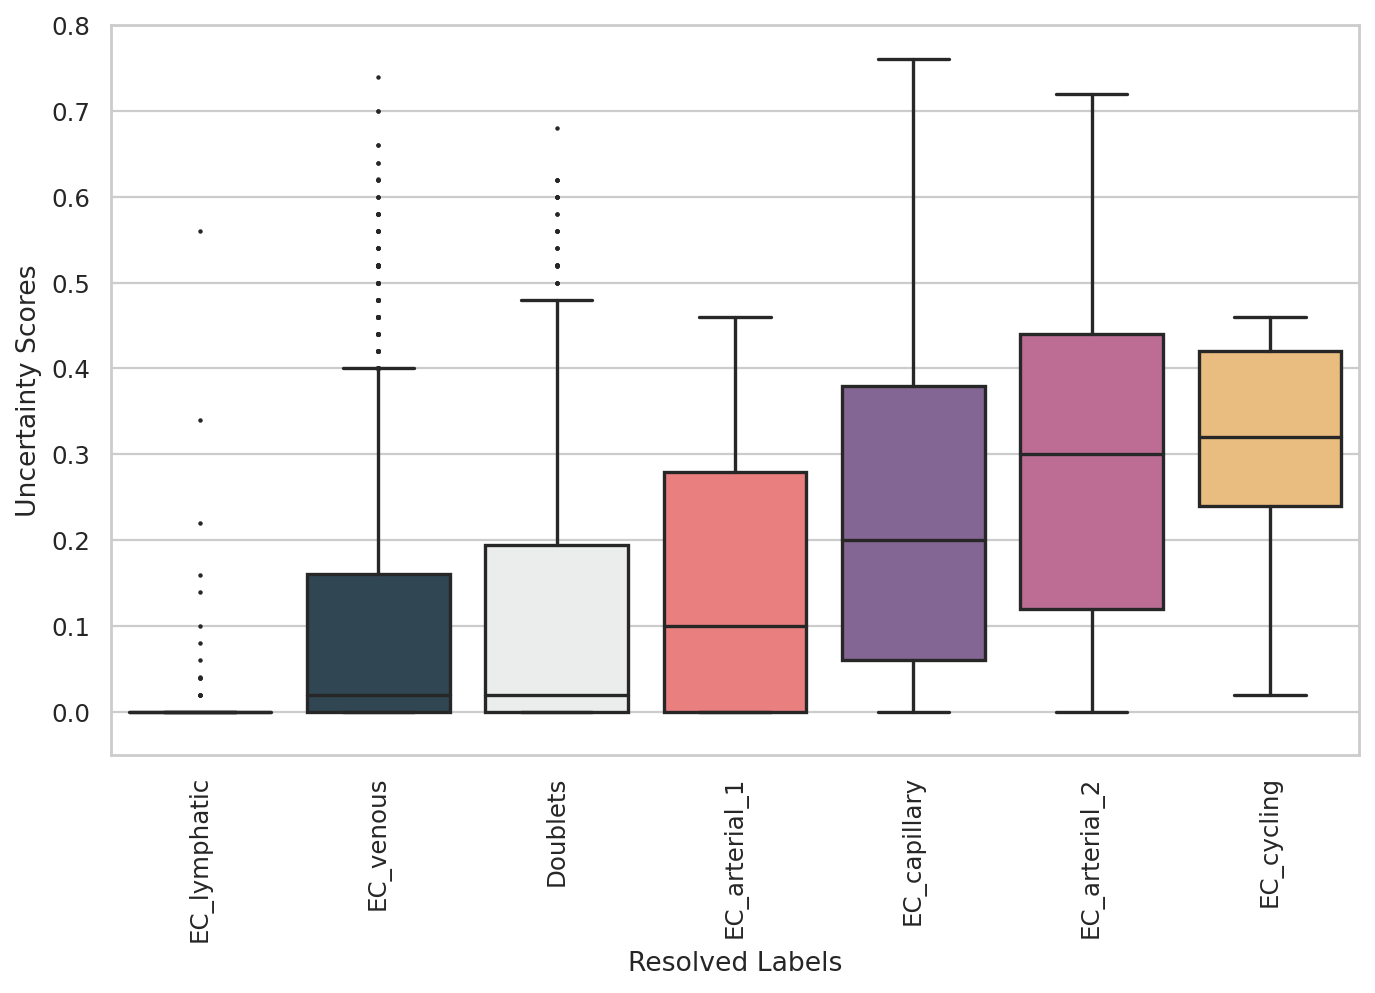

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, but seaborn can enhance the style

# Assuming adata is your AnnData object

# Combine the two variables into a DataFrame for easier plotting
data_to_plot = adata.obs[['fine_predicted_labels_uncertainty', 'fine_predicted_labels_resolved']]

# Use seaborn for better styling (optional)
sns.set(style="whitegrid")

mean_uncertainty = data_to_plot.groupby('fine_predicted_labels_resolved')['fine_predicted_labels_uncertainty'].mean()

# Sort the categories based on mean uncertainty
sorted_categories = mean_uncertainty.sort_values().index

# Create a box and whisker plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
ax = sns.boxplot(x='fine_predicted_labels_resolved', y='fine_predicted_labels_uncertainty', 
            data=data_to_plot,palette=colors,order=sorted_categories,flierprops=dict(marker='o', markerfacecolor='gray', markersize=1))

# Add labels and title
plt.xticks(rotation=90)
plt.xlabel('Resolved Labels')
plt.ylabel('Uncertainty Scores')
ax.set_ylim(-0.05, 0.8)

# Save the plot as a PDF file
plt.savefig('Endo_boxplot_uncertainty_scores.pdf', format='pdf')

# Show the plot
plt.show()

In [41]:
#related to revisions point 2.10 "Have you done differential gene expression analysis of the unknonw cells versus the annotated cells in their cluster?"

In [42]:
adata

AnnData object with n_obs × n_vars = 8121 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_spli

In [15]:
annot = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/disease_annot/resolved_annot/Endo_disease_annot.csv',index_col=0)

In [16]:
annot

,fine_predicted_labels_uncertflagged,fine_predicted_labels_resolved
index,,
AAAGCAAAGAGCTGGT-4918STDY7273964,EC_arterial_2,EC_arterial_2
AACCATGTCCAGTAGT-4918STDY7273964,EC_arterial_1,EC_arterial_1
AACTGGTGTAGCTCCG-4918STDY7273964,EC_arterial_2,EC_arterial_2
AAGCCGCTCGTACGGC-4918STDY7273964,EC_venous,EC_venous
AAGGCAGGTAGCACGA-4918STDY7273964,EC_venous,EC_venous
...,...,...
TTGACTTTCCTACAGA-GSM4546346,EC_venous,EC_venous
TTGCGTCTCCCAAGTA-GSM4546346,EC_arterial_2,EC_arterial_2
TTTACTGCAAACCCAT-GSM4546346,EC_venous,EC_venous


In [17]:
adata.obs['fine_predicted_labels_uncertflagged'] = annot.fine_predicted_labels_uncertflagged

In [18]:
adata.obs['fine_predicted_labels_resolved'] = annot.fine_predicted_labels_resolved

In [19]:
adata.obs['unknown_clusterlabel'] = adata.obs['fine_predicted_labels_uncertflagged'].astype(str) + '_' + adata.obs['fine_predicted_labels_resolved'].astype(str)

In [20]:
adata.obs['unknown_clusterlabel'].value_counts()

EC_venous_EC_venous            3119
EC_capillary_EC_capillary      2246
EC_arterial_2_EC_arterial_2     681
Doublets_Doublets               472
Unknown_EC_capillary            421
EC_arterial_1_EC_arterial_1     397
EC_lymphatic_EC_lymphatic       392
Unknown_EC_arterial_2           161
Unknown_EC_venous               153
Unknown_Doublets                 42
EC_cycling_EC_cycling            36
Unknown_EC_lymphatic              1
Name: unknown_clusterlabel, dtype: int64

In [21]:
adata.X.max()

4818.0

In [22]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [23]:
adata_compare = adata[~adata.obs.unknown_clusterlabel.isin(['Unknown_EC_lymphatic'])].copy()

         Falling back to preprocessing with `sc.pp.pca` and default params.


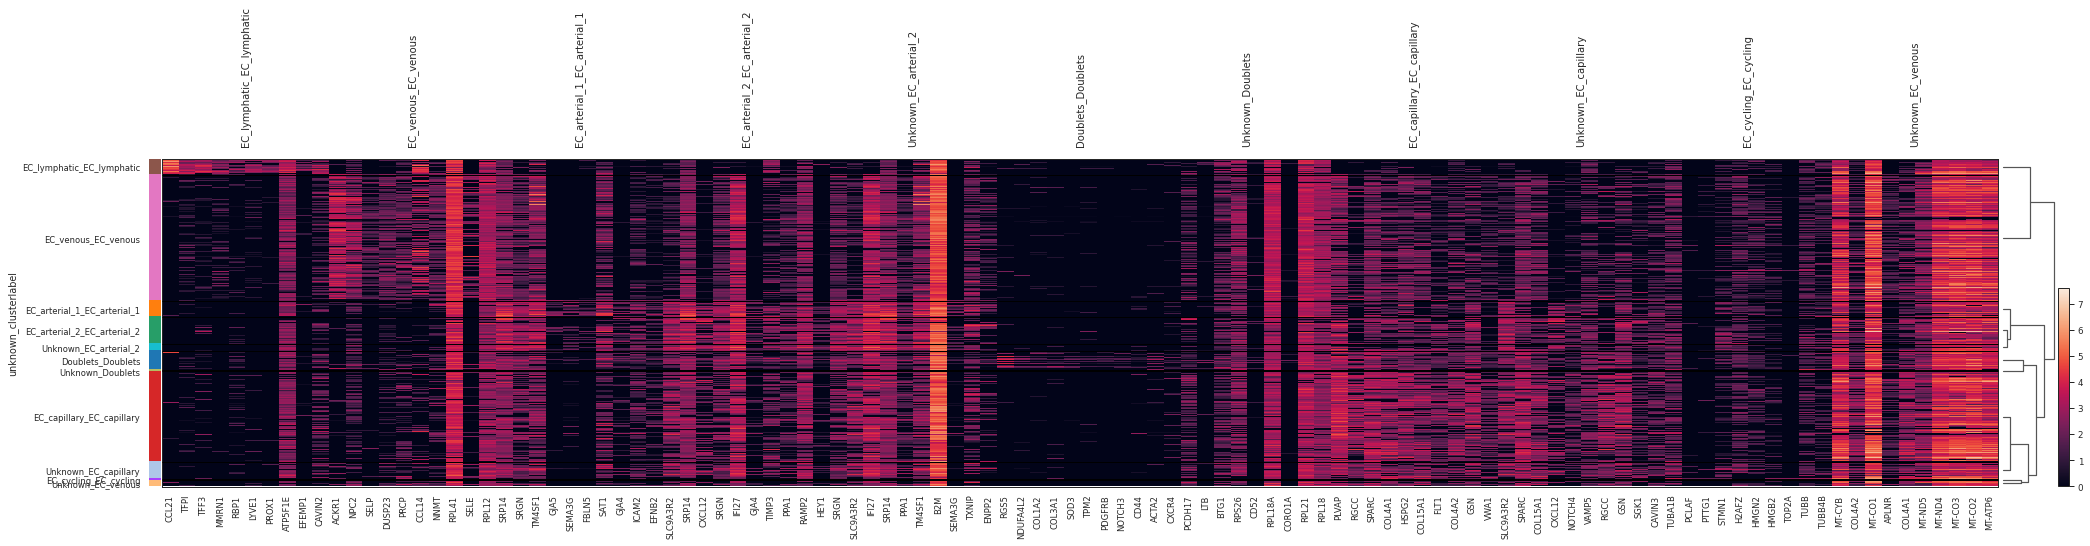

In [24]:
sc.tl.rank_genes_groups(adata_compare, 'unknown_clusterlabel', method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(adata_compare, show_gene_labels=True)

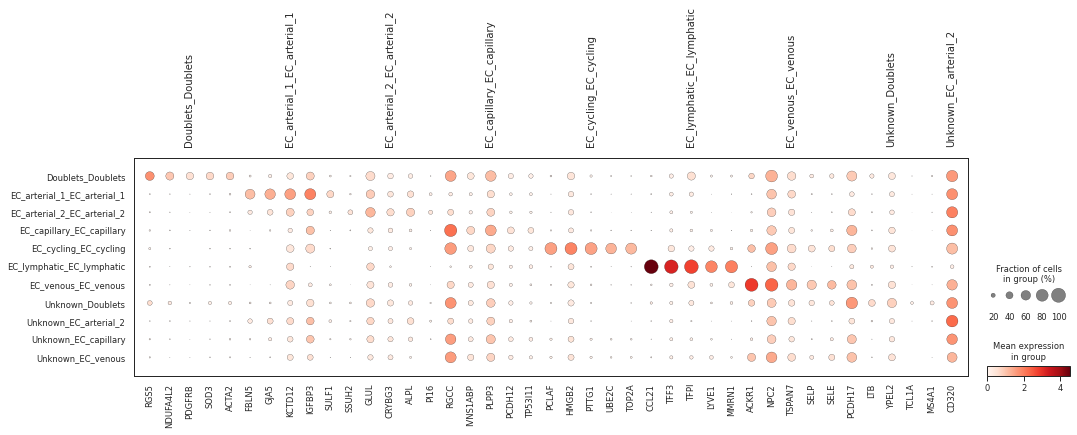

In [25]:
import sys
sys.path.append("/home/jovyan/ao15/Megagut/")
from re5_combine import *
adata_compare.raw = adata_compare.copy()
mkst = calc_marker_stats(adata_compare, groupby="unknown_clusterlabel")
mks = filter_marker_stats(mkst[2], min_frac_diff=0.1, min_mean_diff=0.1, max_next_frac=0.5, max_next_mean=0.95, strict=False, how='or')
plot_markers(adata_compare, groupby='unknown_clusterlabel', mks=mks)

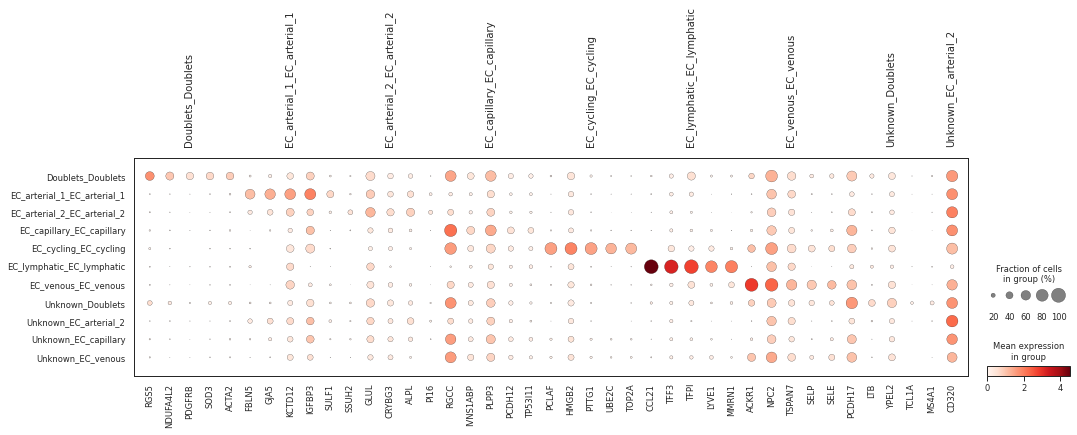

In [26]:
plot_markers(adata_compare, groupby='unknown_clusterlabel', mks=mks,save='Endo_unknown_specificDGE.pdf')